### Load required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow.keras import regularizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Load the data

In [2]:
df = pd.read_csv('./data/creditcard.csv', index_col=0)
print(df.shape)
df.head()

(284807, 30)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,,,,,,,,,,,,,,,,,,,,,
0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Data check

In [3]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [4]:
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [5]:
df.isnull().values.any()

False

In [6]:
df = df.drop(['Amount'], axis=1)

### Train/test split

In [7]:
frauds = df[df.Class == 1]
#normal = df[df.Class == 0].sample(1000)
normal = df[df.Class == 0]
print("Frauds shape: {}".format(frauds.shape))
print("Normal shape: {}".format(normal.shape))

Frauds shape: (492, 29)
Normal shape: (284315, 29)


In [8]:
data = pd.concat([frauds, normal])
data.shape

(284807, 29)

In [9]:
X_train, X_test = train_test_split(data, test_size=0.3, random_state=42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
X_train = X_train.values

X_test, y_test = X_test.drop(['Class'], axis=1).values, X_test['Class'].values

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (199013, 28)
X_test shape: (85443, 28)


### Visualize the data with TSNE and PCA

In [10]:
x1 = df[df.Class == 1]
x2 = df[df.Class == 0].sample(1000)

dfd = x1.append(x2).sample(frac=1).reset_index(drop=True)
x = dfd.drop(['Class'], axis=1).values
y = dfd['Class'].values

SEED = 42

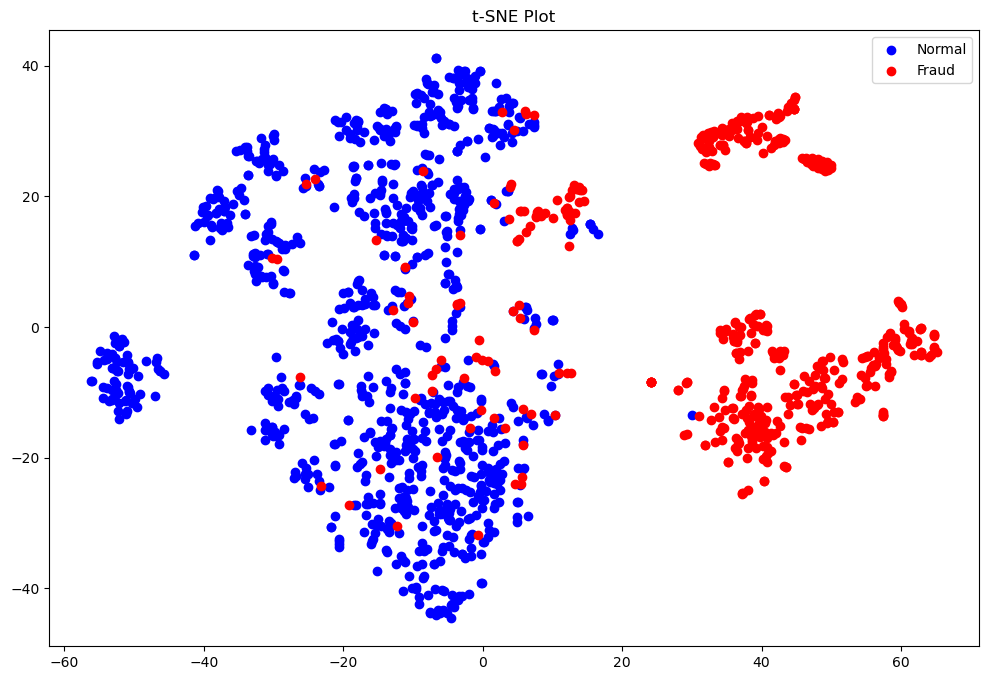

In [11]:
tsne = TSNE(n_components=2, random_state=SEED)
xtsne = tsne.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(xtsne[np.where(y==0), 0], y=xtsne[np.where(y==0), 1], color="blue", label='Normal')
plt.scatter(x=xtsne[np.where(y==1), 0], y=xtsne[np.where(y==1), 1], color="red", label='Fraud')
plt.title('t-SNE Plot')
plt.legend()
plt.show()

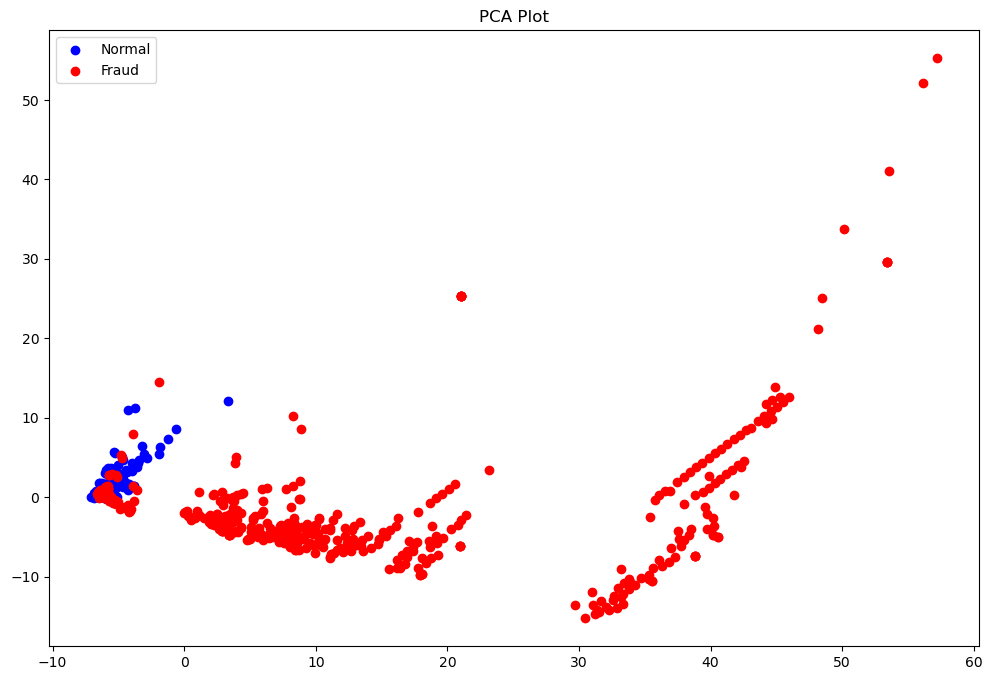

In [12]:
pca = PCA(n_components=2, random_state=SEED)
xpca = pca.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(x=xpca[np.where(y==0), 0], y=xpca[np.where(y==0), 1], color="blue", label='Normal')
plt.scatter(x=xpca[np.where(y==1), 0], y=xpca[np.where(y==1), 1], color="red", label='Fraud')
plt.title('PCA Plot')
plt.legend()
plt.show()

#### Normalize the data

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit_transform(X_train);
scaler.transform(X_test);

### AutoEncoder Model

In [11]:
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim, ))
encoder = Dense(14, activation="relu")(input_layer)
encoder = Dense(7, activation="relu")(encoder)
encoder = Dense(4, activation="relu")(encoder)

encoder = Dense(2, activation="relu")(encoder)

decoder = Dense(4, activation="relu")(encoder)
decoder = Dense(7, activation="relu")(decoder)
decoder = Dense(14, activation='relu')(decoder)
decoder = Dense(input_dim)(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense (Dense)               (None, 14)                406       
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 4)                 32        
                                                                 
 dense_3 (Dense)             (None, 2)                 10        
                                                                 
 dense_4 (Dense)             (None, 4)                 12        
                                                                 
 dense_5 (Dense)             (None, 7)                 35    

In [12]:
epochs = 100
batch_size = 32
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="./pth/fraudAE.h5", verbose=0, save_best_only=True)

### Training

In [13]:
history = autoencoder.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    callbacks=[checkpointer]).history

Epoch 1/100
5598/5598 [==============================] - 16s 2ms/step - loss: 0.7588 - accuracy: 0.4161 - val_loss: 0.6665 - val_accuracy: 0.4572
Epoch 2/100
5598/5598 [==============================] - 14s 3ms/step - loss: 0.6753 - accuracy: 0.4732 - val_loss: 0.6428 - val_accuracy: 0.4848
Epoch 3/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.6545 - accuracy: 0.4861 - val_loss: 0.6266 - val_accuracy: 0.4903
Epoch 4/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.6386 - accuracy: 0.4799 - val_loss: 0.6150 - val_accuracy: 0.4794
Epoch 5/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.6211 - accuracy: 0.4750 - val_loss: 0.6002 - val_accuracy: 0.4887
Epoch 6/100
5598/5598 [==============================] - 14s 3ms/step - loss: 0.6098 - accuracy: 0.4822 - val_loss: 0.5930 - val_accuracy: 0.4825
Epoch 7/100
5598/5598 [==============================] - 18s 3ms/step - loss: 0.5967 - accuracy: 0.4833 - val_loss: 0.5847 -

Epoch 57/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.5423 - accuracy: 0.4887 - val_loss: 0.5415 - val_accuracy: 0.5016
Epoch 58/100
5598/5598 [==============================] - 16s 3ms/step - loss: 0.5419 - accuracy: 0.4917 - val_loss: 0.5441 - val_accuracy: 0.4903
Epoch 59/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.5422 - accuracy: 0.4898 - val_loss: 0.5381 - val_accuracy: 0.5035
Epoch 60/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.5411 - accuracy: 0.4865 - val_loss: 0.5389 - val_accuracy: 0.4995
Epoch 61/100
5598/5598 [==============================] - 18s 3ms/step - loss: 0.5417 - accuracy: 0.4875 - val_loss: 0.5392 - val_accuracy: 0.4952
Epoch 62/100
5598/5598 [==============================] - 16s 3ms/step - loss: 0.5417 - accuracy: 0.4862 - val_loss: 0.5404 - val_accuracy: 0.5022
Epoch 63/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.5430 - accuracy: 0.4859 - val_loss: 0

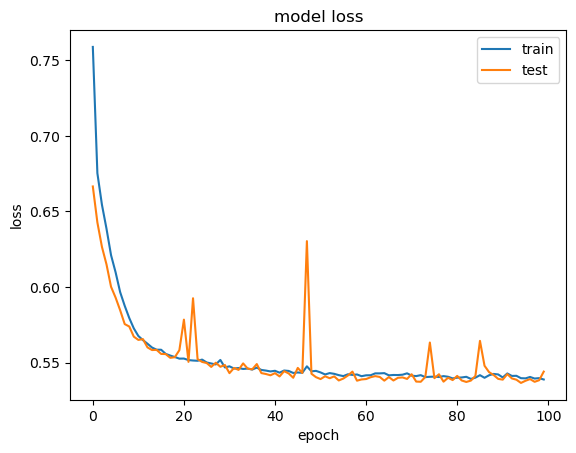

In [14]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

### Test

In [15]:
ae = load_model('./pth/fraudAE.h5')

In [16]:
predictions = ae.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

2671/2671 [==============================] - 5s 2ms/step


,reconstruction_error,true_class
count,85443.000000,85443.00000
mean,0.569145,0.00165
std,1.856562,0.04059
min,0.059089,0.00000
25%,0.224596,0.00000
50%,0.351982,0.00000
75%,0.607368,0.00000
max,111.521852,1.00000


In [17]:
threshold = 2.9

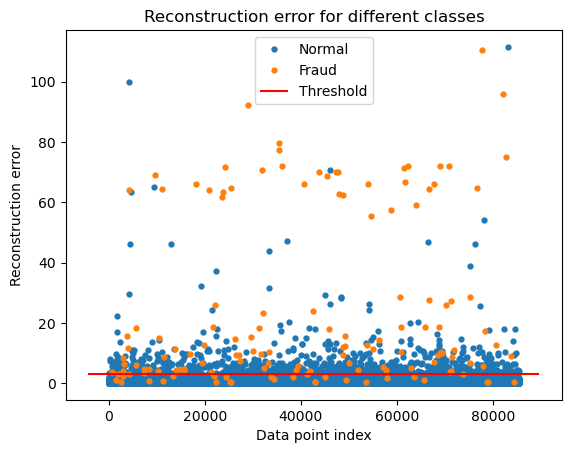

In [18]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

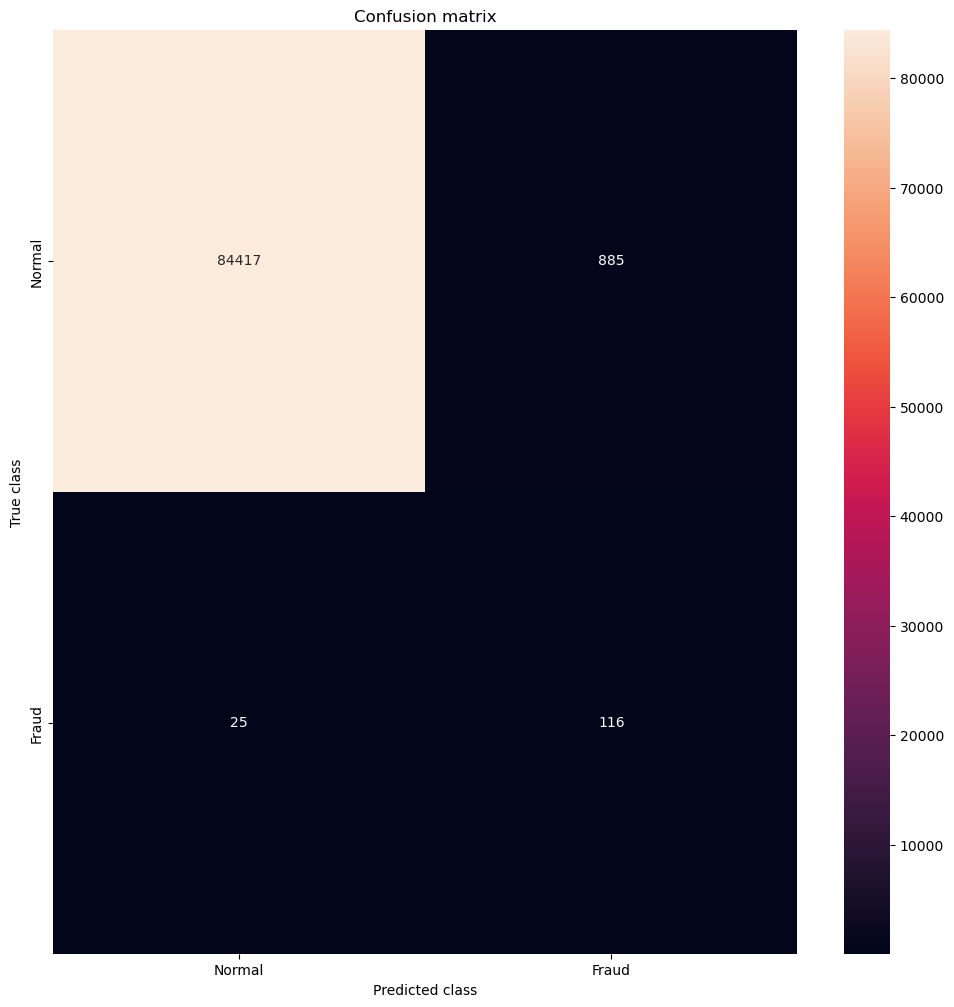

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
LABELS = ['Normal','Fraud']

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Visualize the latent space

In [20]:
inp_layer = ae.input
out_layer = ae.layers[4].output

encoder = Model(inputs=inp_layer, outputs=out_layer)

In [21]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense (Dense)               (None, 14)                406       
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 4)                 32        
                                                                 
 dense_3 (Dense)             (None, 2)                 10        
                                                                 
Total params: 553 (2.16 KB)
Trainable params: 553 (2.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2671/2671 [==============================] - 4s 1ms/step


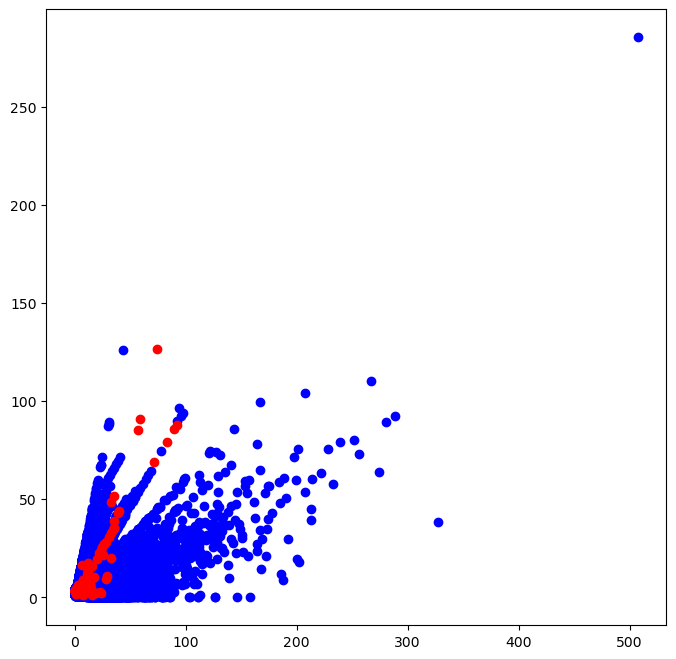

In [22]:
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

X_encoded = np.vstack((X_train_encoded, X_test_encoded))
y_main = np.hstack((np.zeros(len(X_train)), y_test))

encoded_df = pd.DataFrame(np.hstack((X_encoded, y_main[np.newaxis].transpose())))

plt.subplots(figsize=(8,8))
plt.scatter(encoded_df[encoded_df[2]==0][0],encoded_df[encoded_df[2]==0][1], color='blue', label='Normal')
plt.scatter(encoded_df[encoded_df[2]==1][0],encoded_df[encoded_df[2]==1][1], color='red', label='Fraud');